<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/RunTime_saving_Fitabase_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install glob2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from glob import glob
import os
import pandas as pd
path = "/content/drive/MyDrive/Iqram Sir/Fitabase data pulls - seperate"

#Function

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

def get_content(patient_folder_adrs):

  post_adrs = sorted(glob(patient_folder_adrs+"/*"))[0]
  

  pre_adrs = sorted(glob(patient_folder_adrs+"/*"))[1]

  for i in glob(post_adrs+"/*"):
    content = i.split("_")
    if "1min" in content:
      post_1min = i
    if "minuteCaloriesNarrow" in content:
      post_cal = i
    if "minuteMETsNarrow" in content:
      post_met = i


  for i in glob(pre_adrs+"/*"):
    content = i.split("_")
    if "1min" in i.split("_"):
      pre_1min = i
    if "minuteCaloriesNarrow" in content:
      pre_cal = i
    if "minuteMETsNarrow" in content:
      pre_met = i
 
  return post_1min, post_cal,post_met, pre_1min, pre_cal, pre_met



def signle_sample(df_1min, df_cal,df_met):
  list_1 = list(df_1min["Time"])
  list_2 = list(df_cal["ActivityMinute"])
  #df_met = mets_minute_refine(df_met,min)
  list_3 = list(df_met["ActivityMinute"])


  hr = []
  aee = []
  time = []
  mets = []

  if len(list_1)>len(list_2):
    for i in tqdm(list_1):
      if i in list_2 and i in list_3:
        hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
        aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
        mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
        time.append(i)

  else:
    for i in tqdm(list_2):
      if i in list_1 and i in list_3:
        hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
        aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
        mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
        time.append(i)

  d={
    "Time" : time,
     "HR(BPM)" : hr,
     "aEE(kJ/min)":aee,
     "METs" : mets
  }

  dataFrame = pd.DataFrame.from_dict(d)
  return dataFrame




from datetime import datetime

def formate24(t):
  time = t.split(" ")
  m2 = time[1]+" "+time[2]
  in_time = datetime.strptime(m2, "%I:%M:%S %p")
  out_time = datetime.strftime(in_time, "%H:%M:%S")
  return out_time


def dif_min(start_time, end_time):
  t1 = datetime.strptime(start_time, "%H:%M:%S")
  t2 = datetime.strptime(end_time, "%H:%M:%S")

  delta = t2 - t1

  return delta.total_seconds()/60





#-------------------------------------------------------------------------------

def range_list(k):
  list_of = []
  main_list = []

  for i in range(len(k)-1):
 
    if k[i+1]-k[i] == 1:
      list_of.append(k[i])
    else:
      list_of.append(k[i])
      main_list.append(list_of)
      list_of=[]
    if i == len(k)-2:
      if k[i+1]-k[i] == 1:
        list_of.append(k[i+1])
        main_list.append(list_of)
      else:
        main_list.append([k[i+1]])
  
  return main_list


def range_list_time(k):
  list_of = []
  main_list = []

  for i in tqdm(range(len(k)-1)):
    if dif_min(formate24(k[i]),formate24(k[i+1])) == 0:
      continue
    if dif_min(formate24(k[i]),formate24(k[i+1])) == 1:
      list_of.append(k[i])
    else:
      list_of.append(k[i])
      main_list.append(list_of)
      list_of=[]
    if i == len(k)-2:
      if dif_min(formate24(k[i]),formate24(k[i+1])) == 1:
        list_of.append(k[i+1])
        main_list.append(list_of)
      else:
        main_list.append([k[i+1]])

  return main_list


#Sample Test for single subject

In [5]:
subject = '002-JR'



for i in glob(path+"/*"):
  #get_contenct(i)
  if subject in i.split("/"):
    Post_1min,Post_cal,Post_met, Pre_1min,Pre_cal,Pre_met = get_content(i)

df_post_1min = pd.read_csv(Post_1min)
df_post_cal = pd.read_csv(Post_cal)
df_post_met = pd.read_csv(Post_met)

df_pre_1min = pd.read_csv(Pre_1min)
df_pre_cal = pd.read_csv(Pre_cal)
df_pre_met = pd.read_csv(Pre_met)



In [6]:
d = signle_sample(df_pre_1min,df_pre_cal,df_pre_met)

  0%|          | 0/21600 [00:00<?, ?it/s]

In [111]:
d.head(-10)

,Time,HR(BPM),aEE(kJ/min),METs
0,12/8/2021 4:16:00 PM,84,7.664879,15
1,12/8/2021 4:17:00 PM,78,6.131903,12
2,12/8/2021 4:18:00 PM,75,6.642895,13
3,12/8/2021 4:19:00 PM,73,6.642895,13
4,12/8/2021 4:20:00 PM,75,15.329757,30
...,...,...,...,...
18755,12/22/2021 11:45:00 PM,81,6.131903,12
18756,12/22/2021 11:46:00 PM,80,6.642895,13
18757,12/22/2021 11:47:00 PM,80,6.642895,13
18758,12/22/2021 11:48:00 PM,80,6.131903,12


In [13]:
tr = range_list_time(list(d['Time']))

for i in range(len(tr)):
  if i ==15:
    li = tr[i]
    print(engine(d,tr[i]),i)

  0%|          | 0/18769 [00:00<?, ?it/s]

[[1, 7, -6], [9, 30, 31, 33]] 15




---



---



In [9]:
tr = range_list_time(list(d['Time']))

  0%|          | 0/18769 [00:00<?, ?it/s]

In [14]:
first_list = []
first_met = []
for i in li:
  first_list.append((i, list(d.query("Time == '"+i+"'")['HR(BPM)'])[0]))
  first_met.append(list(d.query("Time == '"+i+"'")['HR(BPM)'])[0])

In [15]:
sort_list = sorted(first_met,reverse=True)

In [16]:
pick_index = []

for i in range(len(first_list)):
  if first_list[i][-1] in sort_list[0:10]:
    pick_index.append(i)
    print(first_list[i],i)

('12/11/2021 5:06:00 PM', 81) 0
('12/11/2021 5:09:00 PM', 83) 3
('12/11/2021 5:10:00 PM', 82) 4
('12/11/2021 5:12:00 PM', 82) 6
('12/11/2021 5:13:00 PM', 90) 7
('12/11/2021 5:14:00 PM', 89) 8
('12/11/2021 5:15:00 PM', 93) 9
('12/11/2021 5:16:00 PM', 86) 10
('12/11/2021 5:17:00 PM', 106) 11
('12/11/2021 5:18:00 PM', 97) 12
('12/11/2021 5:26:00 PM', 81) 20


In [17]:
p = range_list(pick_index)
p

[[0], [3, 4], [6, 7, 8, 9, 10, 11, 12], [20]]

 m min HR recovery

In [18]:



pick_point = []

for i in p:
  if len(i) > 1:
      pick_point.append(max(first_list[i[0]:i[-1]]))


In [19]:
pick_point

[('12/11/2021 5:09:00 PM', 83), ('12/11/2021 5:17:00 PM', 106)]

In [21]:





main_list = []
for i in pick_point:

  start_index = first_list.index(i)
  temp_list = []
  for j in range(5):
    if len(first_list) == start_index+j+1: break
    
    if first_list[start_index+j][-1]>first_list[start_index+j+1][-1]:
      print()
      print(first_list[start_index+j][-1],first_list[start_index+j+1][-1])
      temp_list.append(first_list[start_index][-1]-first_list[start_index+j+1][-1])
  main_list.append(temp_list)



83 82

82 76

90 89

106 97

97 76

76 75

76 73


In [136]:
main_list

[[13, 16], [3, 3, 5], []]

In [119]:
len(first_list)

318



---



---



In [8]:

def engine(d,tr):
  first_list = []
  first_met = []
  for i in tr:
    first_list.append((i, list(d.query("Time == '"+i+"'")['HR(BPM)'])[0]))
    first_met.append(list(d.query("Time == '"+i+"'")['HR(BPM)'])[0])

  sort_list = sorted(first_met,reverse=True)



  pick_index = []
  for i in range(len(first_list)):
    if first_list[i][-1] in sort_list[0:10]:
      pick_index.append(i)



  p = range_list(pick_index)


  pick_point = []

  for i in p:
    if len(i) > 1:
        pick_point.append(max(first_list[i[0]:i[-1]]))




  main_list = []
  for i in pick_point:

    start_index = first_list.index(i)
    temp_list = []
    for j in range(5):
      if len(first_list) == start_index+j+1: break
      
      if first_list[start_index+j][-1]>first_list[start_index+j+1][-1]:
        temp_list.append(first_list[start_index][-1]-first_list[start_index+j+1][-1])
    main_list.append(temp_list)

  return main_list


In [141]:
engine(d)

[[13, 16], [3, 3, 5], []]



---



---



In [149]:
for i in more_8_or:
  for j in i:
    print(j, list(d.query("Time == '"+j+"'")['METs'])[0])
  break

12/8/2021 4:16:00 PM 15
12/8/2021 4:17:00 PM 12
12/8/2021 4:18:00 PM 13
12/8/2021 4:19:00 PM 13
12/8/2021 4:20:00 PM 30
12/8/2021 4:21:00 PM 12
12/8/2021 4:22:00 PM 32
12/8/2021 4:23:00 PM 12
12/8/2021 4:24:00 PM 12
12/8/2021 4:25:00 PM 13
12/8/2021 4:26:00 PM 13
12/8/2021 4:27:00 PM 28
12/8/2021 4:28:00 PM 13
12/8/2021 4:29:00 PM 13
12/8/2021 4:30:00 PM 13
12/8/2021 4:31:00 PM 13
12/8/2021 4:32:00 PM 13
12/8/2021 4:33:00 PM 12
12/8/2021 4:34:00 PM 12
12/8/2021 4:35:00 PM 12
12/8/2021 4:36:00 PM 10
12/8/2021 4:37:00 PM 12
12/8/2021 4:38:00 PM 12
12/8/2021 4:39:00 PM 12
12/8/2021 4:40:00 PM 12
12/8/2021 4:41:00 PM 12
12/8/2021 4:42:00 PM 12
12/8/2021 4:43:00 PM 12
12/8/2021 4:44:00 PM 12
12/8/2021 4:45:00 PM 12
12/8/2021 4:46:00 PM 12
12/8/2021 4:47:00 PM 13
12/8/2021 4:48:00 PM 13
12/8/2021 4:49:00 PM 13
12/8/2021 4:50:00 PM 12
12/8/2021 4:51:00 PM 12
12/8/2021 4:52:00 PM 13
12/8/2021 4:53:00 PM 13
12/8/2021 4:54:00 PM 13
12/8/2021 4:55:00 PM 15
12/8/2021 4:56:00 PM 15
12/8/2021 4:57:0

In [150]:
li = i


In [151]:
high_count = 0
high_met = []
final = []

for j in li:

  m = list(d.query("Time == '"+j+"'")['METs'])[0]
  if 35 < m < 45:
    high_count += 1
    high_met.append((j,m))
  else:
    if high_count >= 5:
      final.append(high_met)
    high_count = 0
    high_met = []


In [152]:
final

[[('12/8/2021 5:38:00 PM', 44),
  ('12/8/2021 5:39:00 PM', 44),
  ('12/8/2021 5:40:00 PM', 38),
  ('12/8/2021 5:41:00 PM', 44),
  ('12/8/2021 5:42:00 PM', 38),
  ('12/8/2021 5:43:00 PM', 40),
  ('12/8/2021 5:44:00 PM', 40),
  ('12/8/2021 5:45:00 PM', 38)]]

In [153]:



for i in final:
  last_active.append(i[-1][0])
  for j in range(li.index(i[-1][0])+1,len(li)):
    m = list(d.query("Time == '"+li[j]+"'")['METs'])[0]
    if m<35:
      i.append((li[j],m))
    else:
      break
      
    

In [154]:
final

[[('12/8/2021 5:38:00 PM', 44),
  ('12/8/2021 5:39:00 PM', 44),
  ('12/8/2021 5:40:00 PM', 38),
  ('12/8/2021 5:41:00 PM', 44),
  ('12/8/2021 5:42:00 PM', 38),
  ('12/8/2021 5:43:00 PM', 40),
  ('12/8/2021 5:44:00 PM', 40),
  ('12/8/2021 5:45:00 PM', 38),
  ('12/8/2021 5:46:00 PM', 30),
  ('12/8/2021 5:47:00 PM', 14),
  ('12/8/2021 5:48:00 PM', 15),
  ('12/8/2021 5:49:00 PM', 15),
  ('12/8/2021 5:50:00 PM', 15),
  ('12/8/2021 5:51:00 PM', 30)]]

In [168]:
for i in final:
  for j in i:
    print(j[-1])

44
44
38
44
38
40
40
38
30
14
15
15
15
30


In [172]:

recovery_time = []
flage = 0
for i in final:
  count_recover=0
  count_rest = 0
  
  for j in i:
    print(j)
    if 35>j[-1]>25:
      if flage ==1:
        break
      count_recover += 1
    elif 25>j[-1]>10:
      if count_recover == 0:
        break
      count_rest += 1
      flage = 1
    else:continue

  if count_rest >= 3:
    recovery_time.append(count_recover)
  

      

('12/8/2021 5:38:00 PM', 44)
('12/8/2021 5:39:00 PM', 44)
('12/8/2021 5:40:00 PM', 38)
('12/8/2021 5:41:00 PM', 44)
('12/8/2021 5:42:00 PM', 38)
('12/8/2021 5:43:00 PM', 40)
('12/8/2021 5:44:00 PM', 40)
('12/8/2021 5:45:00 PM', 38)
('12/8/2021 5:46:00 PM', 30)
('12/8/2021 5:47:00 PM', 14)
('12/8/2021 5:48:00 PM', 15)
('12/8/2021 5:49:00 PM', 15)
('12/8/2021 5:50:00 PM', 15)
('12/8/2021 5:51:00 PM', 30)


In [173]:
recovery_time


[1]



---



---



In [186]:
def single_segment_recovery_time(d,li):
  #choosing the peak atleast 5 points
  high_count = 0
  high_met = []
  last_active = []
  final = []

  for j in li:

    m = list(d.query("Time == '"+j+"'")['METs'])[0]
    if 39 < m < 51:
      high_count += 1
      high_met.append((j,m))
    else:
      if high_count >= 5:
        final.append(high_met)
      high_count = 0
      high_met = []




  #selecting data up to next pick point
  for i in final:
    last_active.append(i[-1][0])
    for j in range(li.index(i[-1][0])+1,len(li)):
      m = list(d.query("Time == '"+li[j]+"'")['METs'])[0]
      if m<40:
        i.append((li[j],m))
      else:
        break
  print(*final,sep="\n")
  """  recovery_time = []
  flage = 0
  for i in range(len(final)):
    count_recover=0
    count_rest = 0
    for j in final[i]:
      if 40>j[-1]>30:
        if flage ==1:
          break
        count_recover += 1
      else:
        if count_recover == 0:
          break
        count_rest += 1
        flage = 1

    if count_rest >= 3:
      recovery_time.append(count_recover)

  return recovery_time"""
  recovery_time = []
  flage = 0
  for i in final:
    count_recover=0
    count_rest = 0
    
    for j in i:
     # print(j)
      if 40>j[-1]>30:
        if flage ==1:
          break
        count_recover += 1
      elif 30>j[-1]>20:
        if count_recover == 0:
          break
        count_rest += 1
        flage = 1
      else:continue

    if count_rest >= 3:
      recovery_time.append(count_recover)
  return recovery_time


In [187]:



#chosing minimum lenth 8 continous values (exercie time(5min)+ resting time(3))
tr = range_list_time(list(d['Time']))
for i in tqdm(tr):
  if len(i)>8:
    print(single_segment_recovery_time(d,i))




  0%|          | 0/113 [00:00<?, ?it/s]

[('12/8/2021 5:34:00 PM', 46), ('12/8/2021 5:35:00 PM', 44), ('12/8/2021 5:36:00 PM', 46), ('12/8/2021 5:37:00 PM', 48), ('12/8/2021 5:38:00 PM', 44), ('12/8/2021 5:39:00 PM', 44), ('12/8/2021 5:40:00 PM', 38)]
[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]
[('12/12/2021 1:41:00 PM', 40), ('12/12/2021 1:42:00 PM', 44), ('12/12/2021 1:43:00 PM', 42), ('12/12/2021 1:44:00 PM', 50), ('12/12/2021 1:45:00 PM', 42), ('12/12/2021 1:46:00 PM', 48), ('12/12/2021 1:47:00 PM', 42), ('12/12/2021 1:48:00 PM', 44), ('12/12/2021 1:49:00 PM', 30), ('12/12/2021 1:50:00 PM', 15), ('12/12/2021 1:51:00 PM', 30), ('12/12/2021 1:52:00 PM', 26)]
[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]
[('12/13/2021 1:47:00 PM', 42), ('12/13/2021 1:48:00 PM', 50), ('12/13/2021 1:49:00 PM', 50), ('12/13/2021 1:50:00 PM', 46), ('12/13/2021 1:51:00 PM', 48), ('12/13/2021 1:52:00 PM', 36), ('12/13/2021 1:53:00 PM', 15)]
[('12/13/2021 4:11:00 PM', 44), ('12/13/2021 4:1

##Pre Regression Line
<font color = 'blue'>Details:</font> This section will plot the regression line of `pre condition`.<br>


In [ ]:
d = signle_sample(df_pre_1min,df_pre_cal,df_pre_met)

  0%|          | 0/80640 [00:00<?, ?it/s]

In [ ]:
#@title Select METs Ranges { run: "auto" }
option = "25 \u003C METs \u003C= 45" #@param ["0 < METs <= 10","10 < METs <= 25" ,"25 < METs <= 45", "45 < METs <=60","60<METs"]
print('You selected', option)

if option == "0 \u003C METs \u003C= 10":
  upper_lim = 10
  lower_lim = 0
  activity = "Resting"

elif option == "10 \u003C METs \u003C= 25":
  upper_lim = 20
  lower_lim = 10
  activity = "Light_Activity"


elif option == "25 \u003C METs \u003C= 45":
  upper_lim = 40
  lower_lim = 20
  activity = "Moderate_Activity"

elif option == "45 \u003C METs \u003C=60":
  upper_lim = 60
  lower_lim = 40
  activity = "Heavy_Activity"

elif option == "60\u003CMETs":
  upper_lim = 10000
  lower_lim = 60
  activity = "Heavy_Activity"

print("Upper Limit: ",upper_lim)
print("Lower Limit: ",lower_lim)
print("Activity: ",activity)



You selected 25 < METs <= 45
Upper Limit:  45
Lower Limit:  25
Activity:  Moderate_Activity


###Refining

In [ ]:
epoch = 15      #set the epoch number

test_data = mets_minute_refine(d, epoch,upper_lim,lower_lim)
final_data = final_refination(test_data,epoch)
#final_data.to_csv(subject+"_"+"pre"+"_"+activity+".csv",index=False)

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
final_data.shape

(18, 5)

###Ploting

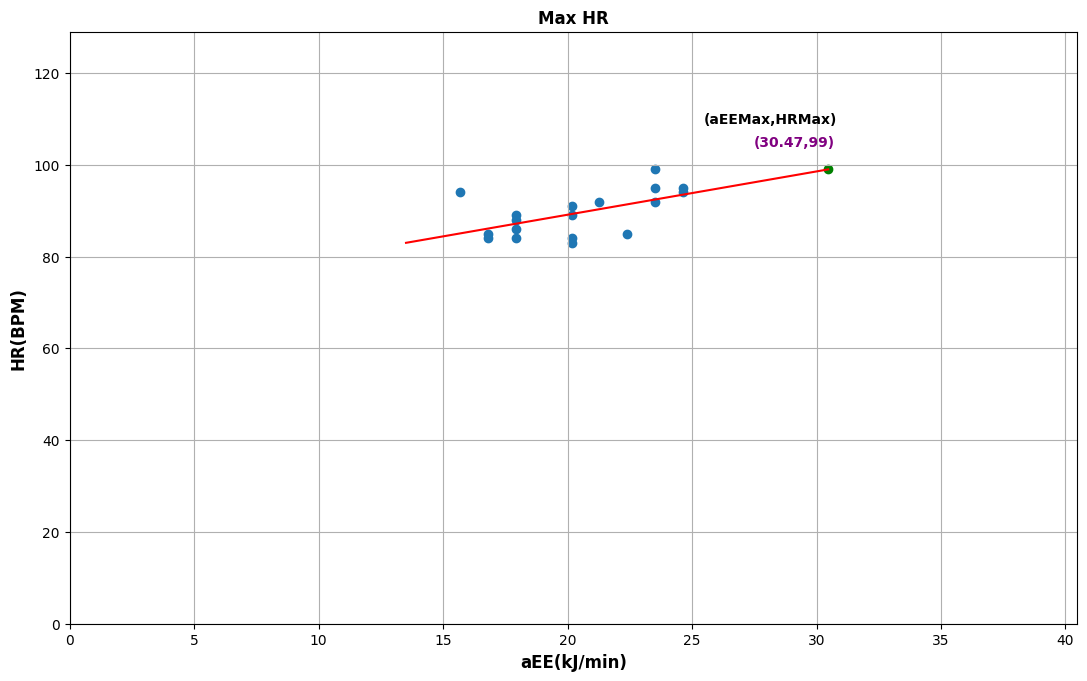

In [ ]:
plot(final_data)

In [ ]:
max_hr_aee(final_data)

(99, 30.47)

##Post Regression Line
<font color = 'blue'>Details:</font> This section will plot the regression line of `post condition`.<br>


In [ ]:
d2 = signle_sample(df_post_1min,df_post_cal,df_post_met)

  0%|          | 0/50400 [00:00<?, ?it/s]

In [ ]:
#@title Select METs Ranges { run: "auto" }
option = "25 \u003C METs \u003C= 45" #@param ["0 < METs <= 10","10 < METs <= 25" ,"25 < METs <= 45", "45 < METs <=60","60<METs"]
print('You selected', option)

if option == "0 \u003C METs \u003C= 10":
  upper_lim = 10
  lower_lim = 0
  activity = "Resting"

elif option == "10 \u003C METs \u003C= 25":
  upper_lim = 45
  lower_lim = 25
  activity = "Light_Activity"


elif option == "25 \u003C METs \u003C= 45":
  upper_lim = 45
  lower_lim = 25
  activity = "Moderate_Activity"

elif option == "45 \u003C METs \u003C=60":
  upper_lim = 60
  lower_lim = 45
  activity = "Heavy_Activity"

elif option == "60\u003CMETs":
  upper_lim = 10000
  lower_lim = 60
  activity = "Heavy_Activity"

print("Upper Limit: ",upper_lim)
print("Lower Limit: ",lower_lim)
print("Activity: ",activity)



You selected 25 < METs <= 45
Upper Limit:  45
Lower Limit:  25
Activity:  Moderate_Activity


###Refining

In [ ]:
epoch = 15        #set the epoch number

test_data = mets_minute_refine(d2, epoch,upper_lim,lower_lim)
final_data = final_refination(test_data,epoch)
#final_data.to_csv(subject+"_"+"post"+"_"+activity+".csv",index=False)

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/3 [00:00<?, ?it/s]

###Ploting

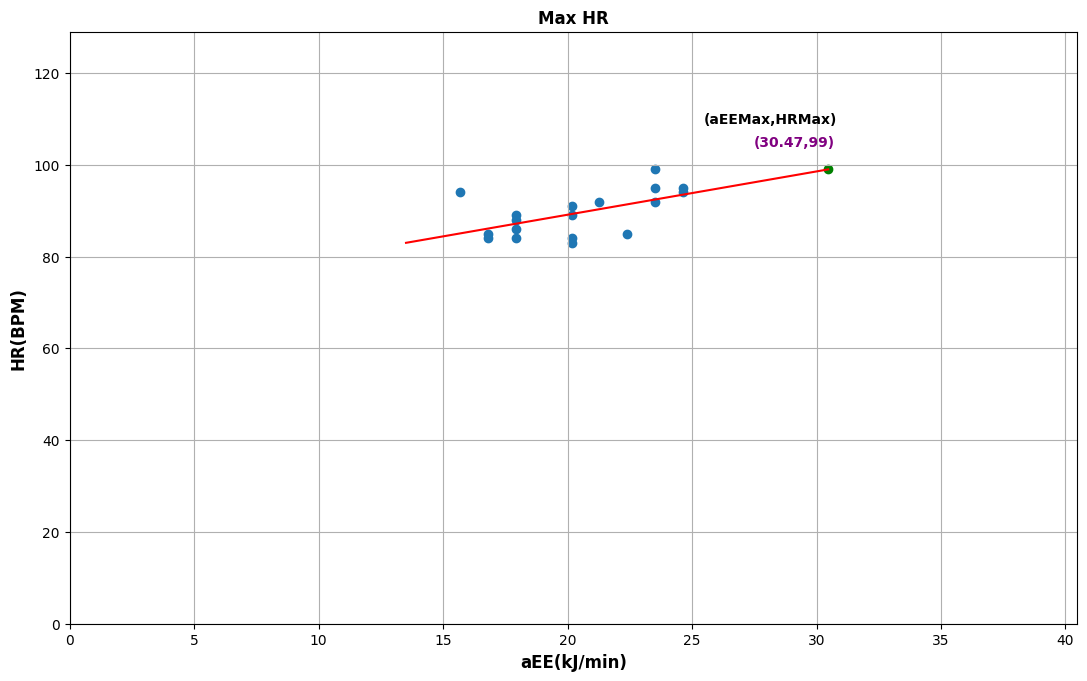

In [ ]:
plot(final_data)

In [ ]:
max_hr_aee(final_data)

(99, 30.47)

#Dataset Creation with all `HR_MAX` and `aEE_MAX` values of all patients.

In [ ]:
#@title Select METs Ranges { run: "auto" }
option = "45 \u003C METs \u003C=60" #@param ["0 < METs <= 10","10 < METs <= 25" ,"25 < METs <= 45", "45 < METs <=60","60<METs"]
print('You selected', option)

if option == "0 \u003C METs \u003C= 10":
  upper_lim = 10
  lower_lim = 0
  activity = "Resting"

elif option == "10 \u003C METs \u003C= 25":
  upper_lim = 45
  lower_lim = 25
  activity = "Light_Activity"


elif option == "25 \u003C METs \u003C= 45":
  upper_lim = 45
  lower_lim = 25
  activity = "Moderate_Activity"

elif option == "45 \u003C METs \u003C=60":
  upper_lim = 60
  lower_lim = 45
  activity = "Heavy_Activity"

elif option == "60\u003CMETs":
  upper_lim = 10000
  lower_lim = 60
  activity = "Heavy_Activity"

print("Upper Limit: ",upper_lim)
print("Lower Limit: ",lower_lim)
print("Activity: ",activity)



You selected 45 < METs <=60
Upper Limit:  60
Lower Limit:  45
Activity:  Heavy_Activity


In [ ]:
file_save_destination = '/content/drive/MyDrive/Iqram Sir/FInal_Ftiabase_HR_aEE_MAX/'+activity+'_HR_aEE_MAX.csv'

In [ ]:

epoch = 15


if os.path.exists(file_save_destination)==False:
  main_dict = {
      "Patient_Id" : [],
      "Condition" : [],
      "HR_MAX(BPM)" : [],
      "aEE_MAX(kJ/min)": []
  }

  df = pd.DataFrame.from_dict(main_dict)
  df.to_csv(file_save_destination,index=False)



p_id = []
condition = []
hr_max = []
aee_max = []

for i in tqdm(sorted(glob(path+"/*"))):
  test_dataset = pd.read_csv(file_save_destination)
  print()
  print()
  sub =  os.path.basename(i)
  print("Subject processing: ",sub)
  Post_1min, Post_cal,Post_met, Pre_1min, Pre_cal,Pre_met = get_content(i)

  if 'pre' not in list(test_dataset.query("Patient_Id == '"+sub+"'")['Condition']):
    p_id.append(sub)
    condition.append('pre')
    df_pre_1min = pd.read_csv(Pre_1min)
    df_pre_cal = pd.read_csv(Pre_cal)
    df_pre_met = pd.read_csv(Pre_met)
    print("Pre Condition In Process:")
    d = signle_sample(df_pre_1min,df_pre_cal,df_pre_met)
    test_data = mets_minute_refine(d, epoch,upper_lim,lower_lim)
    final_data = final_refination(test_data,epoch)
    h,a = max_hr_aee(final_data)
    hr_max.append(h)
    aee_max.append(a)

    temp_dict = {
    "Patient_Id" : [sub],
    "Condition" : ['pre'],
    "HR_MAX(BPM)" : [h],
    "aEE_MAX(kJ/min)": [a]
    }
    temp_df = pd.DataFrame(temp_dict)
    temp_df.to_csv(file_save_destination, mode='a', index=False, header=False)
    print("Pre Condition Process Complete...")


  if 'post' not in list(test_dataset.query("Patient_Id == '"+sub+"'")['Condition']):
    p_id.append(sub)
    condition.append('post')
    df_post_1min = pd.read_csv(Post_1min)
    df_post_cal = pd.read_csv(Post_cal)
    df_post_met = pd.read_csv(Post_met)
    print("Post Condition In Process:")
    d2 = signle_sample(df_post_1min,df_post_cal,df_post_met)
    test_data = mets_minute_refine(d2, epoch,upper_lim,lower_lim)
    final_data = final_refination(test_data,epoch)
    h,a = max_hr_aee(final_data)
    hr_max.append(h)
    aee_max.append(a)
    print("Post Condition Process Complete...")
    print()

  
    temp_dict = {
    "Patient_Id" : [sub],
    "Condition" : ['post'],
    "HR_MAX(BPM)" : [h],
    "aEE_MAX(kJ/min)": [a]
    }
    temp_df = pd.DataFrame(temp_dict)
    temp_df.to_csv(file_save_destination, mode='a', index=False, header=False)
  print(sub," Processing Complete.....")
  print("------------------------------------------------------------------------")


print("Dataset creation complete......")

  0%|          | 0/36 [00:00<?, ?it/s]



Subject processing:  001-JV
Pre Condition In Process:


  0%|          | 0/80640 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


  0%|          | 0/50400 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

001-JV  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  002-JR


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/41760 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

002-JR  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  003-ES


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/14400 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/5 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/48960 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/5 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/3 [00:00<?, ?it/s]

Post Condition Process Complete...

003-ES  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  004-LY
Pre Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/43200 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Post Condition Process Complete...

004-LY  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  005-DF
Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/47075 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Post Condition Process Complete...

005-DF  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  006-MK
Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

006-MK  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  007-DD


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/12960 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/48960 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

007-DD  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  008-KL


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

008-KL  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  010-ML


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/41760 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


  0%|          | 0/46827 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

010-ML  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  011-CR
Pre Condition In Process:


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/4 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Post Condition Process Complete...

011-CR  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  012-DP
Pre Condition In Process:


  0%|          | 0/11520 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/53280 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

012-DP  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  013-MB
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/53280 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/4 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Post Condition Process Complete...

013-MB  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  014-WK
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/3 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Post Condition Process Complete...

014-WK  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  015-BL
Pre Condition In Process:


  0%|          | 0/17280 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/4 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/3 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Post Condition Process Complete...

015-BL  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  016-JN
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Post Condition Process Complete...

016-JN  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  018-PDT


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Time Limit Checking:


0it [00:00, ?it/s]


Unwanted index list making:


0it [00:00, ?it/s]


Refining Dataset:


0it [00:00, ?it/s]

Pre Condition Process Complete...


<ipython-input-28-b29927a3ec39>:134: RuntimeWarning: invalid value encountered in true_divide
  aee_mx = (hr_mx-c)/m


Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/1 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

ERORR:  Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.
Post Condition Process Complete...

018-PDT  Processing Complete.....
------------------------------------------------------------------------


Subject processing:  019-CM
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]